In [2]:
%load_ext autoreload
%autoreload 3

In [7]:
from nnsight import LanguageModel
import torch.nn.functional as F
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import seaborn as sns
from transformers import AutoTokenizer


In [8]:
model_name = "croissantllm/CroissantLLMBase"
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token_id = tokenizer.eos_token_id
nn_model = LanguageModel(
    model_name, device_map="auto", dispatch=True, tokenizer=tokenizer
)
tokenizer = nn_model.tokenizer

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Translation task

Found 97 translations


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy en -> fr: 0.4536082474226804


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy en -> de: 0.14432989690721648


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy en -> ru: 0.28865979381443296


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy en -> zh: 0.3402061855670103


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy fr -> en: 0.5773195876288659


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy fr -> de: 0.16494845360824742


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy fr -> ru: 0.3402061855670103


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy fr -> zh: 0.28865979381443296


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy de -> en: 0.4639175257731959


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy de -> fr: 0.3917525773195876


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy de -> ru: 0.36082474226804123


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy de -> zh: 0.29896907216494845


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy ru -> en: 0.3711340206185567


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy ru -> fr: 0.26804123711340205


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy ru -> de: 0.1134020618556701


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy ru -> zh: 0.23711340206185566


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy zh -> en: 0.14432989690721648


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy zh -> fr: 0.09278350515463918


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy zh -> de: 0.010309278350515464


0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy zh -> ru: 0.18556701030927836


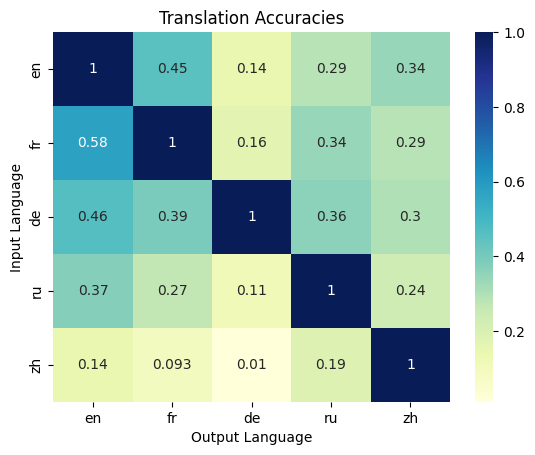

In [18]:
from exp_tools import get_translations, translation_prompts
langs = ["en", "fr", "de", "ru", "zh"]
accuracies = np.ones((len(langs), len(langs)))
df = get_translations(langs)
for i, input_lang in enumerate(langs):
    for j, output_lang in enumerate(langs):
        if input_lang == output_lang:
            continue
        prompts = translation_prompts(df, tokenizer, input_lang, output_lang, output_lang)
        success = 0
        str_prompts = [p.prompt for p in prompts]
        with th.no_grad():
            with nn_model.generate(str_prompts, max_new_tokens=1, pad_token_id=tokenizer.eos_token_id, do_sample=False) as tracer:
                output = nn_model.generator.output.save()
        for ip, p in enumerate(prompts):
            if output[ip][-1].item() in p.target_tokens:
                success += 1
        accuracies[i, j] = success / len(prompts)
        print(f"Accuracy {input_lang} -> {output_lang}: {accuracies[i, j]}")

sns.heatmap(accuracies, annot=True, cmap="YlGnBu", xticklabels=langs, yticklabels=langs)
plt.title("Translation Accuracies")
plt.xlabel("Output Language")
plt.ylabel("Input Language")
plt.show()

## Logit Lens plots

In [26]:
from exp_tools import get_translations, translation_prompts, run_prompts
from utils import plot_ci
def translation_plot(input_lang, target_lang, latent_lang, batch_size=64):
    df = get_translations([input_lang, target_lang, latent_lang])
    prompts = translation_prompts(df, nn_model.tokenizer, input_lang, target_lang, latent_lang)
    target_probs, latent_probs = run_prompts(nn_model, prompts, batch_size=batch_size)
    fig, ax = plt.subplots()
    plot_ci(ax, target_probs, label=target_lang, color="blue")
    plot_ci(ax, latent_probs, label=latent_lang, color="red")
    ax.legend()
    ax.set_title(f"Translation from {input_lang} to {target_lang}")
    return fig, ax

Found 109 translations


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

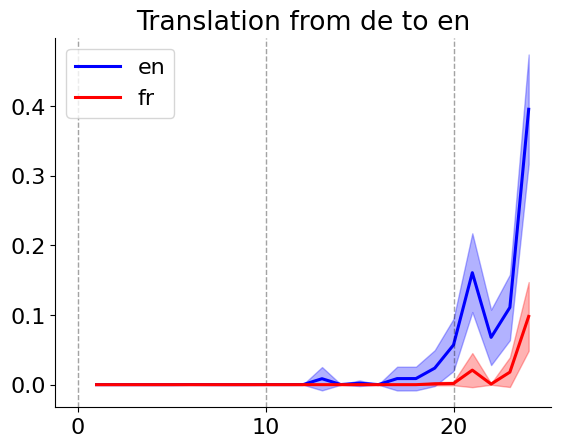

In [27]:
fig, ax = translation_plot("de", "en", "fr")

Found 109 translations


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

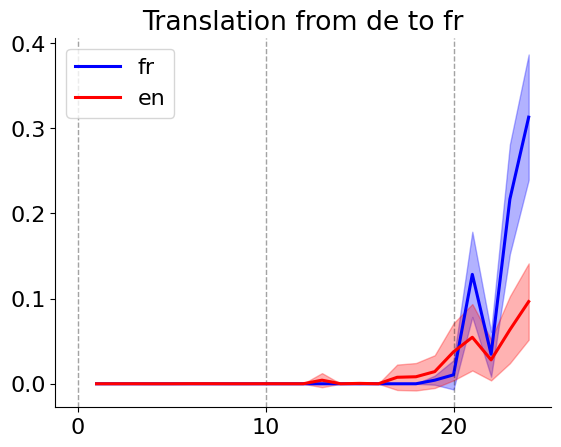

In [28]:
fig, ax = translation_plot("de", "fr", "en")

Found 97 translations


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

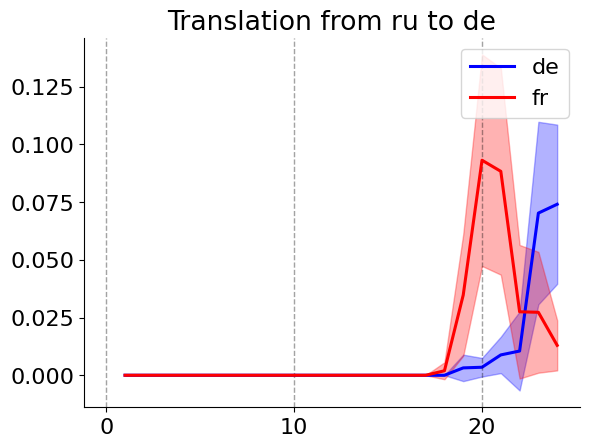

In [29]:
fig, ax = translation_plot("ru", "de", "fr")

Found 105 translations


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

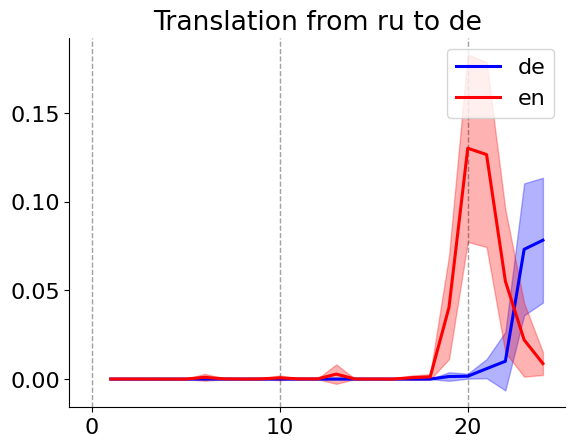

In [30]:
fig, ax = translation_plot("ru", "de", "en")

## Check failures

In [22]:
from utils import StopToken
stop = StopToken.from_string("\n", nn_model.tokenizer)
worst_probs = target_probs[:, -1].argsort()[:5]
for i in worst_probs:
    if target_probs[i, -1] > 0.5:
        break
    tok = [f"{t} : {nn_model.tokenizer.decode(t)}" for t in prompts[i].target_tokens]
    print(
        f"\nPrompt:\n{prompts[i].prompt}\nTokens: {tok}\nProbs: {target_probs[i][-1]}"
    )
    inputs = nn_model.tokenizer(prompts[i].prompt, return_tensors="pt").to(
        nn_model.device
    )
    with nn_model.generate(
        max_new_tokens=10,
        do_sample=False,
        output_scores=True,
        return_dict_in_generate=True,
        stopping_criteria=stop,
    ) as tracer:
        with tracer.invoke(inputs):
            output = nn_model.generator.output.save()

    guess = output.sequences[0][len(inputs.input_ids[0]) :].cpu().numpy()
    str_guess = nn_model.tokenizer.decode(guess).split("\n")[0]
    print(
        f"Guess: {guess}: '{str_guess}', confidence on first out token: {F.softmax(output.scores[0][0], dim=-1)[guess[0]].item() :.4g}"
    )
    print(f"Target: {prompts[i].target_string}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Prompt:
English: "field" - Français: "champ"
English: "south" - Français: "sud"
English: "soil" - Français: "sol"
English: "structure" - Français: "structure"
English: "sea" - Français: "mer"
English: "exchange" - Français: "
Tokens: ['173 : b', '3358 : bou', '2612 : bo', '30357 : bourse', '1138 : b', '13586 : bour', '3307 : bo', '11270 : bour']
Probs: 5.094136213301681e-05


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Guess: [ 244 4601 1709]: 'échange"', confidence on first out token: 0.6757
Target: bourse

Prompt:
English: "eight" - Français: "huit"
English: "cloud" - Français: "nuage"
English: "ocean" - Français: "océan"
English: "door" - Français: "porte"
English: "machine" - Français: "machine"
English: "tie" - Français: "
Tokens: ['2669 : cr', '174 : c', '1116 : c', '16596 : cr', '6335 : cra']
Probs: 9.890893124975264e-05


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Guess: [1333 1108 1709]: 'lien"', confidence on first out token: 0.1094
Target: cravate

Prompt:
English: "summer" - Français: "été"
English: "example" - Français: "exemple"
English: "flower" - Français: "fleur"
English: "face" - Français: "visage"
English: "province" - Français: "province"
English: "ground" - Français: "
Tokens: ['1540 : so', '1756 : so', '1114 : s', '190 : s', '2429 : sol']
Probs: 0.0003854193782899529


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Guess: [1213 1112 1709]: 'terre"', confidence on first out token: 0.9639
Target: sol

Prompt:
English: "square" - Français: "carré"
English: "advance" - Français: "avancer"
English: "return" - Français: "retour"
English: "net" - Français: "filet"
English: "cave" - Français: "grotte"
English: "tea" - Français: "
Tokens: ['1181 : th', '1111 : t', '1276 : th', '191 : t', '5430 : thé']
Probs: 0.0004285074828658253


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Guess: [ 1148 12451  1709]: 'teinture"', confidence on first out token: 0.1799
Target: thé

Prompt:
English: "tower" - Français: "tour"
English: "seven" - Français: "sept"
English: "flower" - Français: "fleur"
English: "song" - Français: "chanson"
English: "meeting" - Français: "réunion"
English: "spring" - Français: "
Tokens: ['189 : r', '1112 : re', '1177 : r', '26866 : ressor', '15832 : ressort', '1942 : ress', '4331 : ress', '1169 : re', '1432 : res', '1312 : res']
Probs: 0.0006349403411149979


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Guess: [1327 1109 6887 1709]: 'printemps"', confidence on first out token: 0.959
Target: ressort


In [19]:
intersect = set([ 1327 , 1109 , 6887 , 1709  ,1686, 16614  , 133 , 1235 , 1206 , 1549])
nl_set = set(stop.stop_tokens)
nl_set.intersection(intersect)
{k: nn_model.tokenizer.decode(k) for k in intersect}

{133: ':',
 16614: 'glish',
 6887: 'temps',
 1709: '"\n',
 1549: 'ven',
 1327: 'pr',
 1235: '"',
 1109: 'in',
 1686: 'En',
 1206: 'se'}

# Models playgroudn

In [48]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "croissantllm/CroissantLLMBase"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, torch_dtype=th.float16, device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# prompt = "The french translation for 'hello' is 'bonjour'\nThe french translation for 'head' is '"
prompt = 'English: "wave" - Français: "onde"\nEnglish: "middle" - Français: "milieu"\nEnglish: "mouth" - Français: "bouche"\nEnglish: "north" - Français: "nord"\nEnglish: "source" - Français: "source"\nEnglish: "eye" - Français: "'
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
tokens = model.generate(**inputs, max_new_tokens=1, do_sample=False)
print(tokenizer.decode(tokens[0]))

# remove bos token
print("\nWithout bos:")
inputs2 = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).to(
    model.device
)
tokens2 = model.generate(**inputs2, max_new_tokens=1, do_sample=False)
print(tokenizer.decode(tokens2[0]))
print(tokens2[0][-1])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> English: "wave" - Français: "onde"
English: "middle" - Français: "milieu"
English: "mouth" - Français: "bouche"
English: "north" - Français: "nord"
English: "source" - Français: "source"
English: "eye" - Français: "oe

Without bos:
English: "wave" - Français: "onde"
English: "middle" - Français: "milieu"
English: "mouth" - Français: "bouche"
English: "north" - Français: "nord"
English: "source" - Français: "source"
English: "eye" - Français: "oe
tensor(4970, device='cuda:0')


In [72]:
tok = tokenizer(["Ceci est vraiment très bien, voici un nombre aléatoire:\t", "NonefzrgrefzefrfeddddddddddddddddddddzfzefaoeihfaoifhaeoihzfrgfhadefaiufaeuhfaiufhaeiuafiufhaihfaiuhfaziuhfaiufhNdzaafezfafezfaefzaefzvefa oud aoudaozuz daoid azoidzoaizdoiahbiefohdzbifzdvobhvffeizbvfdzdcfuzecifzeiuz"], return_tensors="pt", padding=True).to(model.device)
out = model.generate(**tok, max_new_tokens=1, do_sample=False)
tokenizer.decode(out[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><s> Ceci est vraiment très bien, voici un nombre aléatoire:\tThis'

In [56]:
tok

{'input_ids': [[1, 21183], [1, 8571, 21976]], 'attention_mask': [[1, 1], [1, 1, 1]]}